## **Image classification with transformers vs. CNN: Swin**

Finetuning Swin sin aumento de datos.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io
from collections import Counter
import timm
from torch.utils.data import Subset
import multiprocessing
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import copy
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import time
from timm.loss import LabelSmoothingCrossEntropy

SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("Torch version: ", torch. __version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Torch version:  2.6.0+cu124
Device:  cuda


### **Dataset**

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat
!mkdir -p oxford102/jpg
!tar -xzf 102flowers.tgz -C oxford102/jpg

--2025-05-16 02:50:24--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-05-16 02:50:24--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  35.0MB/s    in 10s     

2025-05-16 02:50:35 (31.7 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2025-05-16 02:50:35--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels

In [3]:
label_mat = scipy.io.loadmat("imagelabels.mat")
split_mat = scipy.io.loadmat("setid.mat")

labels = label_mat["labels"][0] 
train_ids = split_mat["trnid"][0]
val_ids = split_mat["valid"][0]
test_ids = split_mat["tstid"][0]

df = pd.DataFrame({
    "image_id": np.arange(1, len(labels) + 1),
    "label": labels,
    "split": "unknown"
})
df.loc[df.image_id.isin(train_ids), "split"] = "train"
df.loc[df.image_id.isin(val_ids), "split"] = "val"
df.loc[df.image_id.isin(test_ids), "split"] = "test"

### **Visualización de Datos**

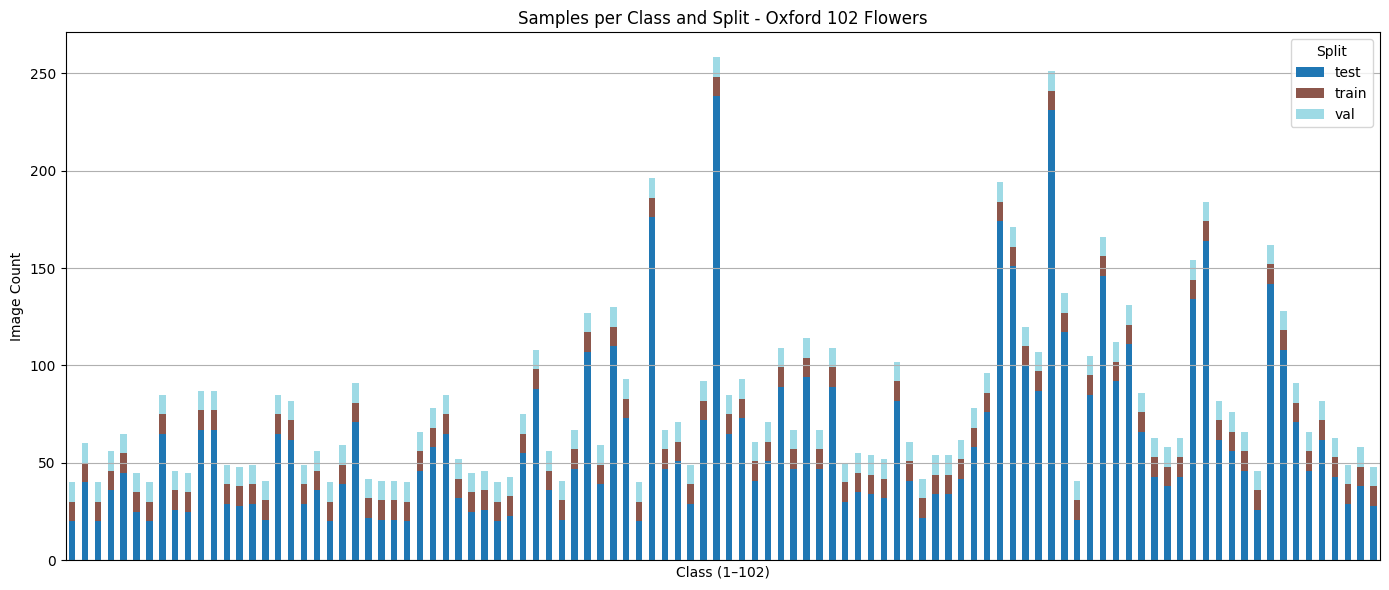

In [4]:
class_split_counts = df.groupby(["label", "split"]).size().unstack(fill_value=0)
class_split_counts.index.name = "Class"
class_split_counts.columns.name = "Split"

class_split_counts.plot(kind='bar', stacked=True, figsize=(14, 6), colormap="tab20")
plt.title("Samples per Class and Split - Oxford 102 Flowers")
plt.xlabel("Class (1–102)")
plt.ylabel("Image Count")
plt.xticks([], []) 
plt.tight_layout()
plt.grid(True)
plt.show()

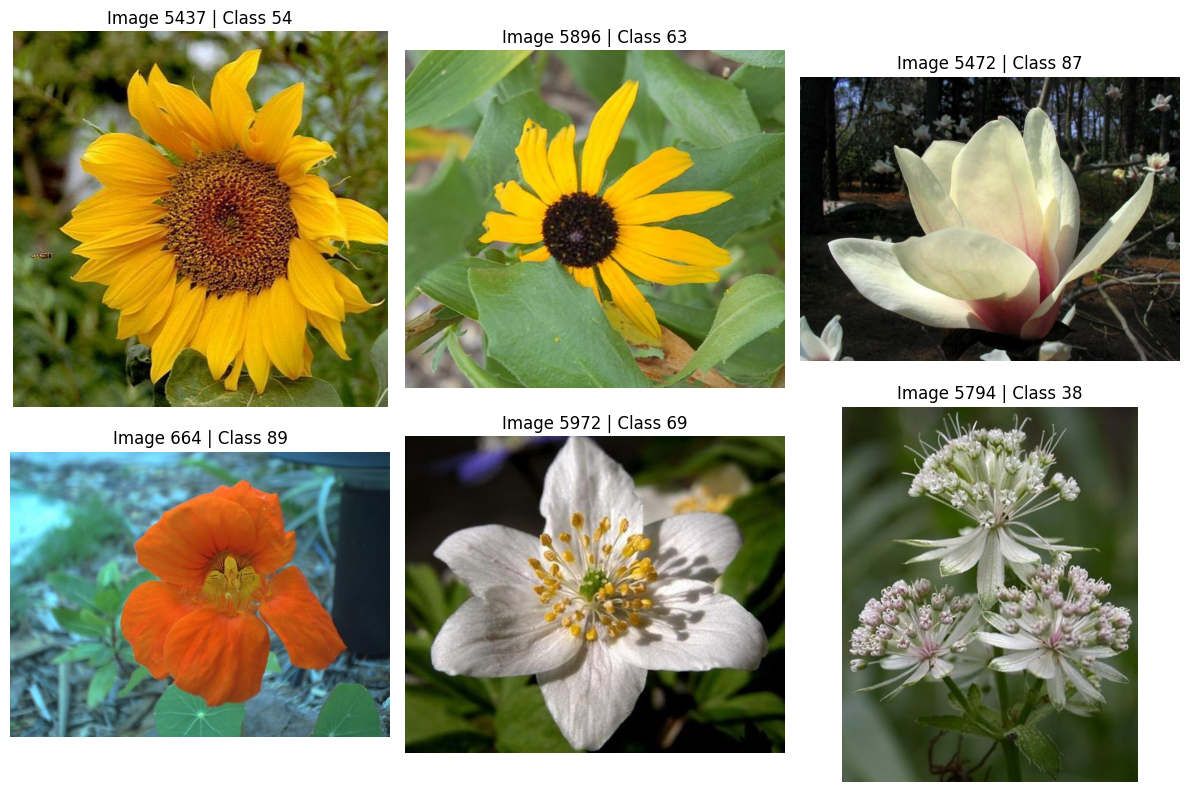

In [5]:
img_dir = "oxford102/jpg/jpg"
sample_ids = df[df["split"] == "train"]["image_id"].sample(6, random_state=42).values

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, img_id in zip(axes.flat, sample_ids):
    img_path = os.path.join(img_dir, f'image_{img_id:05d}.jpg')
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Image {img_id} | Class {labels[img_id - 1]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
class FlowersDataset(Dataset):
    def __init__(self, img_dir, image_ids, labels, transform=None):
        self.img_dir = img_dir
        self.image_ids = image_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, f'image_{img_id:05d}.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.labels[img_id - 1] - 1  # zero-based indexing

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_dir = "oxford102/jpg/jpg"

train_dataset = FlowersDataset(img_dir, train_ids, labels, train_transform)
val_dataset = FlowersDataset(img_dir, val_ids, labels, transform)
test_dataset = FlowersDataset(img_dir, test_ids, labels, transform)

batch_size = 32
num_workers = multiprocessing.cpu_count()-1
print("Num workers", num_workers)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers)

Num workers 3


In [8]:
for images, labels in train_loader:
    print(f"Shape of images from DataLoader: {images.shape}")  # Should be [batch_size, 3, 224, 224]
    print(f"Shape of labels from DataLoader: {labels.shape}")  # Should be [batch_size, 1]
    break

Shape of images from DataLoader: torch.Size([32, 3, 224, 224])
Shape of labels from DataLoader: torch.Size([32])


In [9]:
timm.list_models('swin_base*', pretrained=True)

['swin_base_patch4_window7_224.ms_in1k',
 'swin_base_patch4_window7_224.ms_in22k',
 'swin_base_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_base_patch4_window12_384.ms_in1k',
 'swin_base_patch4_window12_384.ms_in22k',
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k']

### **Load Model**

In [10]:
num_classes = 102
model = timm.create_model('swin_base_patch4_window7_224.ms_in22k_ft_in1k', pretrained=True, 
                          num_classes=num_classes)

# model.classifier = nn.Linear(model.classifier.in_features, num_classes)
in_features = model.get_classifier().in_features
model.reset_classifier(num_classes=num_classes)

epochs = 30
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, min_lr=0.00001)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Params: ", count_parameters(model))

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Params:  86847774


### **Training**

In [11]:
model = model.to(device)
best_val_acc = 0.0
best_model_weights = None 

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

since = time.time()

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item())
    
    train_loss /= len(train_loader)
    train_acc = 100. * train_correct / len(train_dataset)
    
    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_acc = 100. * val_correct / len(val_dataset)

    lr_scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "model_flowers_swin_label_smooth.pt")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("\nBest val Accuracy: ", best_val_acc, " in epoch ", best_epoch)
time_elapsed = time.time() - since
print(f"\nTraining completed in {time_elapsed:.2f} seconds")

Epoch 1/30: 100%|██████████| 32/32 [00:35<00:00,  1.10s/it, loss=1.72]


Epoch 1/30, Train Loss: 3.6809, Train Acc: 32.94%, Val Loss: 1.4379, Val Acc: 92.55%


Epoch 2/30: 100%|██████████| 32/32 [00:34<00:00,  1.08s/it, loss=0.945]


Epoch 2/30, Train Loss: 1.1434, Train Acc: 96.27%, Val Loss: 1.0202, Val Acc: 96.47%


Epoch 3/30: 100%|██████████| 32/32 [00:36<00:00,  1.15s/it, loss=1.02] 


Epoch 3/30, Train Loss: 0.9476, Train Acc: 99.22%, Val Loss: 0.9631, Val Acc: 98.04%


Epoch 4/30: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.866]


Epoch 4/30, Train Loss: 0.8974, Train Acc: 99.61%, Val Loss: 0.9318, Val Acc: 98.53%


Epoch 5/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.84] 


Epoch 5/30, Train Loss: 0.8712, Train Acc: 100.00%, Val Loss: 0.9190, Val Acc: 98.24%


Epoch 6/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.82] 


Epoch 6/30, Train Loss: 0.8500, Train Acc: 99.90%, Val Loss: 0.9119, Val Acc: 98.14%


Epoch 7/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.846]


Epoch 7/30, Train Loss: 0.8494, Train Acc: 100.00%, Val Loss: 0.8967, Val Acc: 98.82%


Epoch 8/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.868]


Epoch 8/30, Train Loss: 0.8395, Train Acc: 99.90%, Val Loss: 0.8919, Val Acc: 99.12%


Epoch 9/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.882]


Epoch 9/30, Train Loss: 0.8321, Train Acc: 100.00%, Val Loss: 0.8873, Val Acc: 99.02%


Epoch 10/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.838]


Epoch 10/30, Train Loss: 0.8292, Train Acc: 99.90%, Val Loss: 0.8906, Val Acc: 98.82%


Epoch 11/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.817]


Epoch 11/30, Train Loss: 0.8237, Train Acc: 100.00%, Val Loss: 0.8929, Val Acc: 98.82%


Epoch 12/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.817]


Epoch 12/30, Train Loss: 0.8242, Train Acc: 100.00%, Val Loss: 0.8879, Val Acc: 98.82%


Epoch 13/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.816]


Epoch 13/30, Train Loss: 0.8245, Train Acc: 100.00%, Val Loss: 0.8860, Val Acc: 99.02%


Epoch 14/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.811]


Epoch 14/30, Train Loss: 0.8229, Train Acc: 100.00%, Val Loss: 0.8872, Val Acc: 99.02%


Epoch 15/30: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it, loss=0.838]


Epoch 15/30, Train Loss: 0.8201, Train Acc: 100.00%, Val Loss: 0.8875, Val Acc: 99.02%


Epoch 16/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.809]


Epoch 16/30, Train Loss: 0.8221, Train Acc: 100.00%, Val Loss: 0.8856, Val Acc: 98.92%


Epoch 17/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.828]


Epoch 17/30, Train Loss: 0.8211, Train Acc: 100.00%, Val Loss: 0.8842, Val Acc: 98.92%


Epoch 18/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.814]


Epoch 18/30, Train Loss: 0.8166, Train Acc: 100.00%, Val Loss: 0.8869, Val Acc: 98.82%


Epoch 19/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.826]


Epoch 19/30, Train Loss: 0.8176, Train Acc: 100.00%, Val Loss: 0.8832, Val Acc: 98.82%


Epoch 20/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.811]


Epoch 20/30, Train Loss: 0.8186, Train Acc: 100.00%, Val Loss: 0.8837, Val Acc: 99.02%


Epoch 21/30: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it, loss=0.81] 


Epoch 21/30, Train Loss: 0.8142, Train Acc: 100.00%, Val Loss: 0.8827, Val Acc: 99.02%


Epoch 22/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.82] 


Epoch 22/30, Train Loss: 0.8211, Train Acc: 99.90%, Val Loss: 0.8815, Val Acc: 99.02%


Epoch 23/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.804]


Epoch 23/30, Train Loss: 0.8142, Train Acc: 100.00%, Val Loss: 0.8848, Val Acc: 98.92%


Epoch 24/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.808]


Epoch 24/30, Train Loss: 0.8142, Train Acc: 100.00%, Val Loss: 0.8822, Val Acc: 98.92%


Epoch 25/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.811]


Epoch 25/30, Train Loss: 0.8126, Train Acc: 100.00%, Val Loss: 0.8844, Val Acc: 98.82%


Epoch 26/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.804]


Epoch 26/30, Train Loss: 0.8108, Train Acc: 100.00%, Val Loss: 0.8844, Val Acc: 98.82%


Epoch 27/30: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it, loss=0.812]


Epoch 27/30, Train Loss: 0.8111, Train Acc: 99.90%, Val Loss: 0.8810, Val Acc: 98.92%


Epoch 28/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.802]


Epoch 28/30, Train Loss: 0.8117, Train Acc: 100.00%, Val Loss: 0.8810, Val Acc: 98.82%


Epoch 29/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.803]


Epoch 29/30, Train Loss: 0.8136, Train Acc: 99.90%, Val Loss: 0.8800, Val Acc: 98.82%


Epoch 30/30: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.807]


Epoch 30/30, Train Loss: 0.8135, Train Acc: 100.00%, Val Loss: 0.8796, Val Acc: 98.73%

Best val Accuracy:  99.11764705882354  in epoch  8

Training completed in 1467.66 seconds


### **Evaluación Validation**

In [12]:
model.load_state_dict(best_model_weights)
model.eval() 

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [13]:
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')  
cm = confusion_matrix(all_labels, all_preds)

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1-score: {f1:.4f}")

Final Accuracy: 0.9912
Final F1-score: 0.9911


### **Evaluación Test**

In [14]:
model.load_state_dict(best_model_weights)
model.eval() 
start = time.time()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
end = time.time()
print(f"Inference time on test set: {end - start:.2f} seconds")

Inference time on test set: 75.86 seconds


In [15]:
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')  
cm = confusion_matrix(all_labels, all_preds)

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1-score: {f1:.4f}")

Final Accuracy: 0.9875
Final F1-score: 0.9850


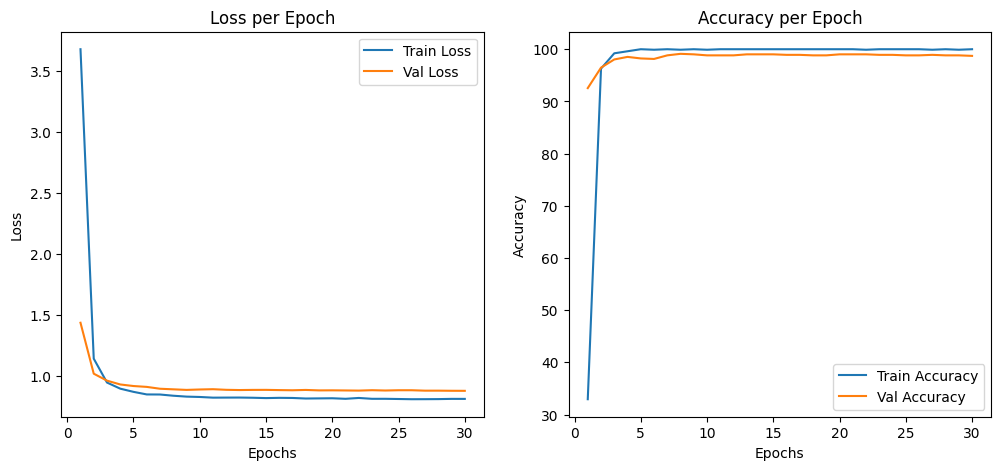

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history['train_loss'], label='Train Loss')
plt.plot(range(1, epochs + 1), history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history['train_acc'], label='Train Accuracy')
plt.plot(range(1, epochs + 1), history['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [17]:
import json

with open('history_swin_best.json', 'w') as f:
    json.dump(history, f, indent=4)